#  <span style="color:blue">Capstone project: the best neighborhood to open a new Vietnamese restaurant in Manhattan</span>.

## In this project we try to find the ideal neighborhood in Manhattan to open a new Vietnamese restaurant. Such neighborhood must satisfy three conditions:  
## - It does not have many Vietnamese restaurants yet  
## - It is a restaurant-friendly neighborhood i.e. it must have many restaurants already
## - It has high average rating of venues

## <span style="color:red">1. Data collection</span>

### This step is almost identical to the lab, with the small modification that we also extract venues id for the rating

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import geopy # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')


Libraries imported.


In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

/bin/sh: wget: command not found
Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

In [8]:
CLIENT_ID = '3F5WVGZS1KTBVQWXIGWF230N0LV4L1C03311FGL1344FE22D' # your Foursquare ID
CLIENT_SECRET = 'PISGMN3FDUKK0GC0EVP2PFRU2CGILN3KFEDLL23Q4Z1EALTT' # your Foursquare Secret
VERSION = '20191214'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3F5WVGZS1KTBVQWXIGWF230N0LV4L1C03311FGL1344FE22D
CLIENT_SECRET:PISGMN3FDUKK0GC0EVP2PFRU2CGILN3KFEDLL23Q4Z1EALTT


In [9]:
LIMIT=100
radius=500

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'], v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category', 'id']
    
    return(nearby_venues)

In [11]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'])

In [12]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3303, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,id
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place,4b4429abf964a52037f225e3
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio,4baf59e8f964a520a6f93be3
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner,4b79cc46f964a520c5122fe3
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop,55f81cd2498ee903149fcc64
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop,4b5357adf964a520319827e3


In [13]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shangha

## <span style="color:red">2. Selecting the restaurants</span>

### Now we extract the restaurants out of the venues

In [14]:
restaurant=manhattan_onehot.columns[manhattan_onehot.columns.str.contains('Restaurant')]


In [15]:
list_restaurant=manhattan_onehot[restaurant]

In [16]:
list_restaurant.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
manhattan_restaurant = pd.concat([manhattan_onehot['Neighborhood'],list_restaurant], axis=1, sort=False)

In [18]:
manhattan_restaurant.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### sum up to find the total number of restaurants of each cuisine

In [19]:
manhattan_restaurant_grouped = list_restaurant.sum().reset_index()
manhattan_restaurant_grouped.sort_values(by=0, inplace=True, ascending=False)

In [20]:
manhattan_restaurant_grouped.reset_index(inplace=True)
manhattan_restaurant_grouped.drop('level_0', axis=1, inplace=True)
manhattan_restaurant_grouped

,index,0
0,Italian Restaurant,125
1,American Restaurant,79
2,Mexican Restaurant,53
3,French Restaurant,52
4,Chinese Restaurant,49
5,Japanese Restaurant,48
6,Sushi Restaurant,44
7,Seafood Restaurant,33
8,Indian Restaurant,30
9,Mediterranean Restaurant,28


### Remove some outcast values

In [21]:
manhattan_restaurant_grouped=manhattan_restaurant_grouped[~manhattan_restaurant_grouped['index'].isin
(['Sushi Restaurant', 'Seafood Restaurant', 'Restaurant', 'Vegetarian / Vegan Restaurant'])]

In [22]:
manhattan_restaurant_grouped.reset_index(inplace=True)
manhattan_restaurant_grouped.drop('level_0', axis=1, inplace=True)
manhattan_restaurant_grouped

/Users/dvu/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,index,0
0,Italian Restaurant,125
1,American Restaurant,79
2,Mexican Restaurant,53
3,French Restaurant,52
4,Chinese Restaurant,49
5,Japanese Restaurant,48
6,Indian Restaurant,30
7,Mediterranean Restaurant,28
8,Thai Restaurant,26
9,New American Restaurant,25


### Extracting the most popular types of restaurant

In [23]:
manhattan_top=manhattan_restaurant_grouped.iloc[0:12]

In [24]:
manhattan_top['index'] = manhattan_top['index'].map(lambda x: x.rstrip('Restaurant'))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
manhattan_top.rename(columns={"index":"Cuisine"}, inplace=True)
manhattan_top.rename(columns={0:"Total number"}, inplace=True)
manhattan_top

/Users/dvu/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Cuisine,Total number
0,Italian,125
1,American,79
2,Mexican,53
3,French,52
4,Chinese,49
5,Japanese,48
6,Indian,30
7,Mediterranean,28
8,Thai,26
9,New American,25


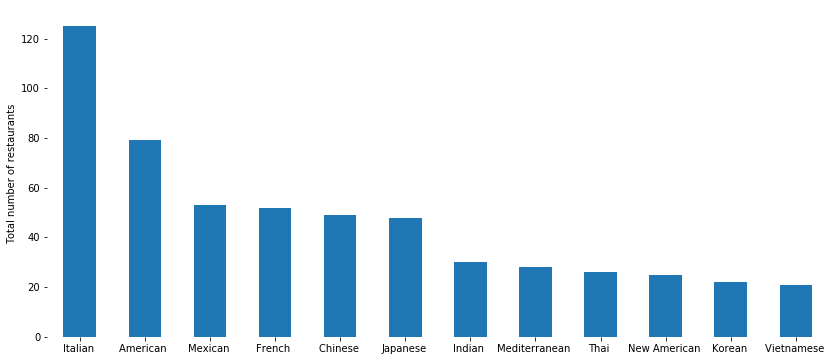

In [26]:
plot1=manhattan_top.plot.bar(x='Cuisine', y='Total number', rot=0, figsize=(14,6), legend=False)
plot1.set_xlabel('')
plot1.set_ylabel('Total number of restaurants')
plot1.spines['top'].set_visible(False)
plot1.spines['right'].set_visible(False)
plot1.spines['bottom'].set_visible(False)
plot1.spines['left'].set_visible(False)
plt.savefig('total_restaurants.pdf')

## <span style="color:red">3. Selecting the Vietnamese restaurants</span>

### Let see there are how many Vietnamese restaurants in each neighborhood

In [27]:
manhattan_viet=manhattan_restaurant[['Neighborhood','Vietnamese Restaurant']].groupby('Neighborhood').sum()

In [28]:
manhattan_viet.sort_values(by='Vietnamese Restaurant', inplace=True, ascending=True)
manhattan_viet.tail()

,Vietnamese Restaurant
Neighborhood,
Gramercy,2
East Village,2
Carnegie Hill,2
Yorkville,2
Chinatown,4


### We see that there are many neighborhood without a Vietnamese restaurants. This will give us plenty of choices to build our new restaurant. But first let us see the total number of restaurants in these neighborhoods

In [29]:
manhattan_restaurant['sum'] = manhattan_restaurant.drop('Neighborhood', axis=1).sum(axis=1)
manhattan_res=manhattan_restaurant[['Neighborhood','sum']].groupby('Neighborhood').sum()
manhattan_res.sort_values(by='sum', inplace=True, ascending=False)
manhattan_res.rename(columns={"sum":"Total number of restaurants"}, inplace=True)

In [63]:
manhattan_res

,Total number of restaurants
Neighborhood,
Chinatown,44
Greenwich Village,43
Turtle Bay,41
East Village,38
Upper West Side,35
Murray Hill,35
West Village,35
Noho,31
Midtown South,30


### Let us box plot the number of restaurants per neighborhood

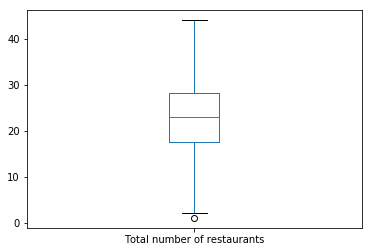

In [31]:
plot2=manhattan_res.plot.box(legend=None)
plot2.set_xlabel('')
plot2.set_ylabel('')
plt.savefig('distribution_restaurants.pdf')

### Compute the standard deviation

In [32]:
np.sqrt(manhattan_res.var())

Total number of restaurants    10.442731
dtype: float64

### Compare the number of Vietnamese restaurants with the total number of restaurants in each neighborhood

In [52]:
manhattan_viet_sum=pd.merge(manhattan_viet, manhattan_res, on='Neighborhood', how='outer')

In [53]:
manhattan_viet_sum

,Vietnamese Restaurant,Total number of restaurants
Neighborhood,,
Battery Park City,0,7
Soho,0,19
Morningside Heights,0,9
Midtown South,0,30
Stuyvesant Town,0,1
Marble Hill,0,2
Manhattanville,0,16
Sutton Place,0,25
West Village,0,35


## <span style="color:red">4. Selecting restaurant-friendly neighborhoods</span>

### Let us consider only neighborhoods with an above average number of restaurants

Compute the average number of restaurants per neighborhood

In [54]:
manhattan_viet_sum['Total number of restaurants'].mean()

22.975

removing restaurants with lower than average number of restaurants

In [55]:
indexNames = manhattan_viet_sum[ manhattan_viet_sum['Total number of restaurants'] < 23 ].index
manhattan_viet_sum.drop(indexNames , inplace=True)
manhattan_viet_sum.reset_index(inplace=True)

new list of restaurant-friendly neighborhoods

In [56]:
manhattan_viet_sum

,Neighborhood,Vietnamese Restaurant,Total number of restaurants
0,Midtown South,0,30
1,Sutton Place,0,25
2,West Village,0,35
3,Lenox Hill,0,27
4,Noho,0,31
5,Turtle Bay,0,41
6,Flatiron,0,29
7,Upper East Side,0,25
8,Clinton,0,25
9,Civic Center,0,24


In [57]:
list(manhattan_viet_sum['Neighborhood'])

['Midtown South',
 'Sutton Place',
 'West Village',
 'Lenox Hill',
 'Noho',
 'Turtle Bay',
 'Flatiron',
 'Upper East Side',
 'Clinton',
 'Civic Center',
 'Upper West Side',
 'Chelsea',
 'Tudor City',
 'Tribeca',
 'Little Italy',
 'Murray Hill',
 'Greenwich Village',
 'East Village',
 'Yorkville',
 'Chinatown']

## <span style="color:red">5. Finding the average rating of each neighborhood</span>

### We want to put our restaurant in a neighborhood with high-rated venues. This will bring more customers and attention to our restaurant

Creating a function to compute the average venues rating of each neighborhood

In [58]:
#create a function to extract the venue rating
def rating(neighbor):
    df=manhattan_venues.loc[manhattan_venues['Neighborhood'].isin([neighbor])]
    rating_list=[]
    for v in df['id']:
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(v, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating_list.append(result['response']['venue']['rating'])
        except:
            rating_list.append(0)
    rating=[x for x in rating_list if x!=0]
    return sum(rating)/len(rating)

### Each call to the Foursquare api to get the rating is a premium call. Due to the restricted number of premium call a free personal account can make, I have to get the rating of each neighborhood one by one to avoid overflowing the allowed quota

In [46]:
rating('Midtown South')

8.615000000000002

In [67]:
rating('Sutton Place')

8.245999999999999

In [68]:
rating('West Village')

8.653999999999996

In [72]:
rating('Lenox Hill')

8.181999999999999

In [76]:
rating('Noho')

8.760824742268039

In [57]:
rating('Turtle Bay')

8.068

In [58]:
rating('Flatiron')

8.838000000000001

In [59]:
rating('Upper East Side')

8.344000000000001

In [60]:
rating('Clinton')

8.200000000000001

In [61]:
rating('Civic Center')

8.45

In [40]:
rating('Upper West Side')

8.214

In [41]:
rating('Chelsea')

8.643000000000004

In [42]:
rating('Tudor City')

7.6962499999999965

In [43]:
rating('Tribeca')

8.335999999999999

In [44]:
rating('Little Italy')

8.771

In [42]:
rating('Murray Hill')

8.382

In [43]:
rating('Greenwich Village')

8.784

In [44]:
rating('East Village')

8.585

In [45]:
rating('Yorkville')

8.026000000000002

In [66]:
rating('Chinatown')

8.453000000000007

In [59]:
rating_list=[8.62,8.25, 8.65,8.18,8.76,8.07, 8.84, 8.34,8.2, 8.45, 8.21, 8.64, 7.69, 8.34, 8.78, 8.38, 8.78, 8.58, 8.03, 8.45]
manhattan_viet_sum['Average rating']=rating_list

In [60]:
manhattan_viet_sum

,Neighborhood,Vietnamese Restaurant,Total number of restaurants,Average rating
0,Midtown South,0,30,8.62
1,Sutton Place,0,25,8.25
2,West Village,0,35,8.65
3,Lenox Hill,0,27,8.18
4,Noho,0,31,8.76
5,Turtle Bay,0,41,8.07
6,Flatiron,0,29,8.84
7,Upper East Side,0,25,8.34
8,Clinton,0,25,8.20
9,Civic Center,0,24,8.45


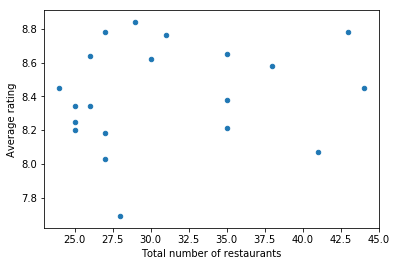

In [42]:
manhattan_viet_sum.plot.scatter(x='Total number of restaurants', y='Average rating')

In [43]:
import seaborn

In [61]:
x=manhattan_viet_sum['Total number of restaurants']
y=manhattan_viet_sum['Average rating']

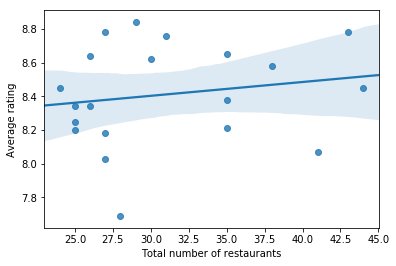

In [62]:
seaborn.regplot(x,y)
plt.savefig('correlation.pdf')

In [46]:
manhattan_viet_sum['Average rating'].mean()

8.411999999999999

Let us drop neighborhoods with lower than average rating

In [47]:
indexNames = manhattan_viet_sum[ manhattan_viet_sum['Average rating'] < 8.41 ].index
manhattan_viet_sum.drop(indexNames , inplace=True)

In [48]:
manhattan_viet_sum

,Neighborhood,Vietnamese Restaurant,Total number of restaurants,Average rating
0,Midtown South,0,30,8.62
2,West Village,0,35,8.65
4,Noho,0,31,8.76
6,Flatiron,0,29,8.84
9,Civic Center,0,24,8.45
11,Chelsea,0,26,8.64
14,Little Italy,1,27,8.78
16,Greenwich Village,2,43,8.78
17,East Village,2,38,8.58
19,Chinatown,4,44,8.45


In [49]:
indexNames = manhattan_viet_sum[ manhattan_viet_sum['Vietnamese Restaurant'] != 0 ].index
manhattan_viet_sum.drop(indexNames , inplace=True)
manhattan_viet_sum

,Neighborhood,Vietnamese Restaurant,Total number of restaurants,Average rating
0,Midtown South,0,30,8.62
2,West Village,0,35,8.65
4,Noho,0,31,8.76
6,Flatiron,0,29,8.84
9,Civic Center,0,24,8.45
11,Chelsea,0,26,8.64


### Let us look at the most popular venues in each of these neighborhoods to make the final decision

In [51]:
num_top_venues = 5
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
for hood in manhattan_viet_sum['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Midtown South----
                 venue  freq
0    Korean Restaurant  0.15
1  Japanese Restaurant  0.05
2                Hotel  0.05
3       Cosmetics Shop  0.04
4            Hotel Bar  0.04


----West Village----
                     venue  freq
0       Italian Restaurant  0.10
1  New American Restaurant  0.06
2             Cocktail Bar  0.04
3           Cosmetics Shop  0.04
4      American Restaurant  0.04


----Noho----
                venue  freq
0  Italian Restaurant  0.05
1   French Restaurant  0.05
2        Cocktail Bar  0.04
3         Art Gallery  0.04
4           Gift Shop  0.03


----Flatiron----
                 venue  freq
0          Yoga Studio  0.04
1                 Café  0.04
2  Japanese Restaurant  0.04
3                  Spa  0.04
4       Clothing Store  0.04


----Civic Center----
                  venue  freq
0  Gym / Fitness Center  0.06
1           Coffee Shop  0.05
2    Italian Restaurant  0.05
3     French Restaurant  0.04
4                 Hotel  0.04


--